In [35]:
import numpy as np
import gym
from gym import spaces

class P2PLendingEnv(gym.Env):
    def __init__(self, num_lenders=10, num_loans=5):
        super(P2PLendingEnv, self).__init__()
        
        # Environment parameters
        self.num_lenders = num_lenders
        self.num_loans = num_loans

        # Loan properties: probability of default and amount requested
        self.loan_probs = np.random.uniform(0.1, 0.9, size=self.num_loans)
        self.loan_amounts = np.random.randint(1, 5, size=self.num_loans)
        self.fico_scores = 850 - (self.loan_probs - 0.1) * (550 / 0.8)

        # Action space: Each lender chooses a loan to fund or does nothing
        self.action_space = spaces.MultiDiscrete([self.num_loans] * self.num_lenders)

        # Observation space: Includes information about loans and partial funding status
        self.observation_space = spaces.Dict({
            "loan_probs": spaces.Box(low=0, high=1, shape=(self.num_loans,), dtype=np.float32),
            #"fico_scores": spaces.Box(low=300, high=850, shape=(self.num_loans,), dtype=np.float32),
            "loan_amounts": spaces.Box(low=0, high=np.inf, shape=(self.num_loans,), dtype=np.float32),
            "current_funding": spaces.Box(low=0, high=np.inf, shape=(self.num_loans,), dtype=np.float32)
        })

        self.reset()

    def reset(self):
        # Reset the funding status of loans
        self.current_funding = np.zeros(self.num_loans, dtype=np.float32)

        # Reset the default status of loans
        self.loan_defaults = np.random.binomial(1, self.loan_probs)

        # Return the initial observation
        return self._get_observation()

    def _get_observation(self):
        return {
            "loan_probs": self.loan_probs,
            "loan_amounts": self.loan_amounts,
            "current_funding": self.current_funding
        }

    def step(self, actions):
        rewards = np.zeros(self.num_lenders, dtype=np.float32)

        # Process each lender's action
        for lender_idx, action in enumerate(actions):
            if action < self.num_loans:  # Lender chose to fund a loan
                self.current_funding[action] += 1  # Increment funding

        # Calculate rewards based on final funding and loan defaults
        for loan_idx in range(self.num_loans):
            if self.current_funding[loan_idx] >= self.loan_amounts[loan_idx]:
                if self.loan_defaults[loan_idx] == 0:  # Successful loan
                    rewards += self.loan_amounts[loan_idx] / self.current_funding[loan_idx]
                else:  # Defaulted loan
                    rewards -= self.loan_amounts[loan_idx] / self.current_funding[loan_idx]

        # Normalize rewards to each lender's contribution
        rewards = np.clip(rewards, -10, 10)

        done = True  # Single round simulation
        return self._get_observation(), rewards, done, {}

    def render(self, mode="human"):
        print(f"Loan Probabilities: {self.loan_probs}")
        print(f"Loan Amounts: {self.loan_amounts}")
        print(f"Current Funding: {self.current_funding}")


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

class LenderAgent(nn.Module):
    def __init__(self, num_loans, hidden_size=64):
        super(LenderAgent, self).__init__()

        # Neural network layers
        self.fc1 = nn.Linear(num_loans * 3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.action_head = nn.Linear(hidden_size, num_loans)  # +1 for "do nothing"
        self.value_head = nn.Linear(hidden_size, 1)

        # Softmax for action probabilities
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action_probs = self.softmax(self.action_head(x))
        state_value = self.value_head(x)
        return action_probs, state_value

class PPOAgent:
    def __init__(self, num_loans, hidden_size=64, lr=3e-4, gamma=0.99, eps_clip=0.2):
        self.policy = LenderAgent(num_loans, hidden_size)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.policy_old = LenderAgent(num_loans, hidden_size)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.mse_loss = nn.MSELoss()

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_probs, _ = self.policy_old(state_tensor)
        action_distribution = torch.distributions.Categorical(action_probs)
        action = action_distribution.sample()
        return action.item(), action_distribution.log_prob(action)

    def compute_returns(self, rewards, dones):
        returns = []
        discounted_sum = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            if done:
                discounted_sum = 0
            discounted_sum = reward + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)
        return returns

    def update(self, memory):
        states = torch.FloatTensor(memory['states'])
        actions = torch.LongTensor(memory['actions']).unsqueeze(1)
        rewards = torch.FloatTensor(memory['rewards'])
        old_log_probs = torch.FloatTensor(memory['log_probs']).unsqueeze(1)

        returns = self.compute_returns(memory['rewards'], memory['dones'])
        returns = torch.FloatTensor(returns).unsqueeze(1)

        for _ in range(4):  # Multiple training epochs per update
            action_probs, state_values = self.policy(states)
            action_distribution = torch.distributions.Categorical(action_probs)

            # Calculate new log probabilities
            new_log_probs = action_distribution.log_prob(actions.squeeze(-1)).unsqueeze(1)

            # Policy loss
            ratios = torch.exp(new_log_probs - old_log_probs)
            advantages = returns - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value loss
            value_loss = self.mse_loss(state_values, returns)

            # Optimize the policy
            self.optimizer.zero_grad()
            (policy_loss + 0.5 * value_loss).backward()
            self.optimizer.step()

        # Update old policy parameters
        self.policy_old.load_state_dict(self.policy.state_dict())


Agent 0 chose action 1 with log prob tensor([-1.7610])
Agent 1 chose action 1 with log prob tensor([-1.5308])
Agent 2 chose action 4 with log prob tensor([-2.0053])
Agent 3 chose action 4 with log prob tensor([-1.5970])
Agent 4 chose action 1 with log prob tensor([-1.5372])
Agent 5 chose action 4 with log prob tensor([-1.4172])
Agent 6 chose action 2 with log prob tensor([-1.3079])
Agent 7 chose action 1 with log prob tensor([-1.3520])
Agent 8 chose action 2 with log prob tensor([-1.6705])
Agent 9 chose action 3 with log prob tensor([-1.6612])
Agent 10 chose action 4 with log prob tensor([-1.6401])
Agent 11 chose action 4 with log prob tensor([-1.6887])
Agent 12 chose action 1 with log prob tensor([-1.6451])
Agent 13 chose action 1 with log prob tensor([-1.8618])
Agent 14 chose action 3 with log prob tensor([-1.4537])
Agent 15 chose action 2 with log prob tensor([-1.1400])
Agent 16 chose action 1 with log prob tensor([-1.5902])
Agent 17 chose action 4 with log prob tensor([-1.5566])
Ag

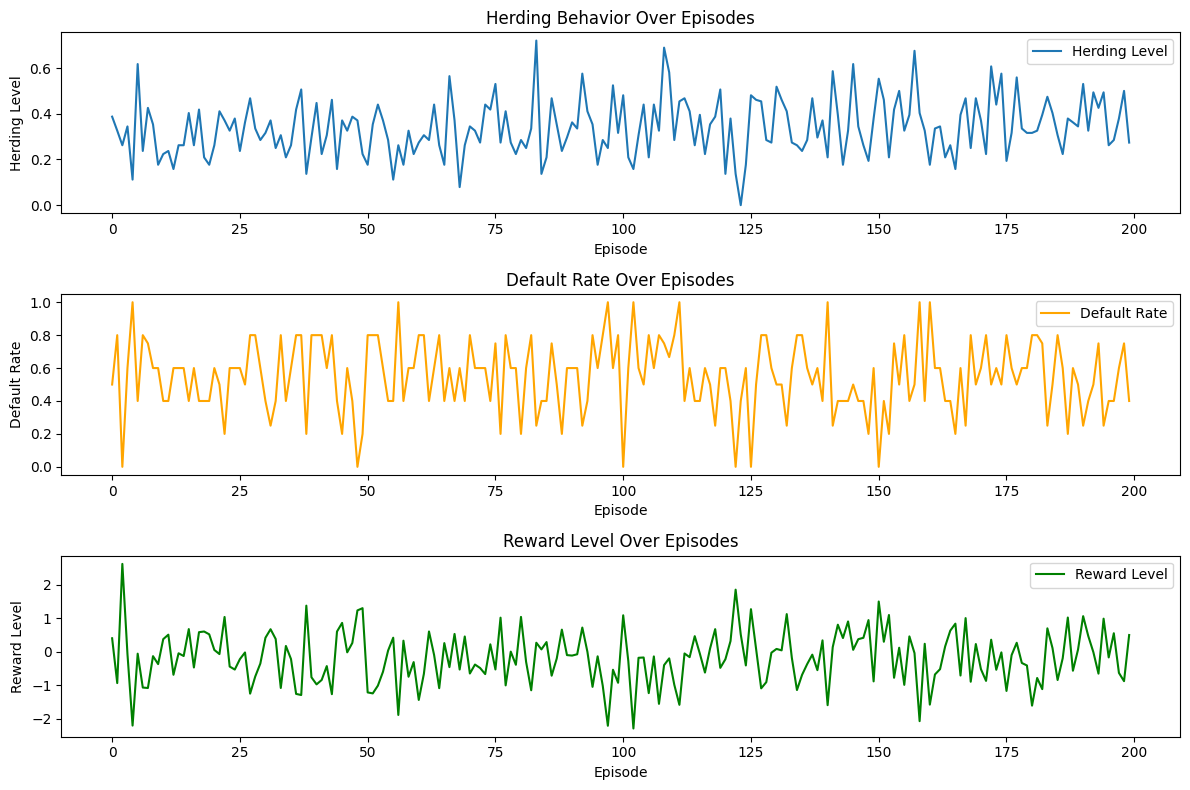

In [37]:
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt

def train_marl(
    num_lenders=10,
    num_loans=5,
    num_episodes=1000,
    max_steps_per_episode=1,
    hidden_size=64,
    lr=3e-4,
    gamma=0.99,
    eps_clip=0.2,
    print_interval=50
):
    """
    Train multiple PPO agents in the P2P lending environment with sequential decision-making.
    Log herding behavior and default rates during training.
    """
    # Initialize environment and agents
    env = P2PLendingEnv(num_lenders=num_lenders, num_loans=num_loans)
    agents = [PPOAgent(num_loans=num_loans, hidden_size=hidden_size, lr=lr, gamma=gamma, eps_clip=eps_clip) for _ in range(num_lenders)]

    # Memory buffers
    memory = {
        'states': [],
        'actions': [],
        'rewards': [],
        'log_probs': [],
        'dones': []
    }

    # Logging variables
    herding_levels = []
    default_rates = []
    reward_levels = []

    # Training loop
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        state_vector = np.concatenate([
            state['loan_probs'], state['loan_amounts'], state['current_funding']
        ])
        episode_rewards = np.zeros(num_lenders)

        actions_taken = []

        for step in range(max_steps_per_episode):
            for lender_idx, agent in enumerate(agents):
                # Each lender acts sequentially, observing the updated state after each action
                action, log_prob = agent.select_action(state_vector)
                print(f"Agent {lender_idx} chose action {action} with log prob {log_prob}")

                # Step the environment with this lender's action
                next_state, rewards, done, _ = env.step([action])  # Single-lender action
                next_state_vector = np.concatenate([
                    next_state['loan_probs'], next_state['loan_amounts'], next_state['current_funding']
                ])

                # Store in memory
                memory['states'].append(state_vector)
                memory['actions'].append([action])
                memory['rewards'].append(rewards[lender_idx])  # Store reward as a scalar
                memory['log_probs'].append([log_prob])
                memory['dones'].append(done)

                state_vector = next_state_vector
                episode_rewards[lender_idx] += rewards[lender_idx]
                actions_taken.append(action)

        # Get funded loans and their defaults
        funded_loans = np.array(env.current_funding) >= np.array(env.loan_amounts)
        loans_defaulted = np.array(env.loan_defaults)[funded_loans]

        # Debugging info: Log loan funding and defaults
        print(f"Episode {episode}: Current Funding: {env.current_funding}")
        print(f"Episode {episode}: Loan Amounts: {env.loan_amounts}")
        print(f"Episode {episode}: Funded Loans: {funded_loans}")
        print(f"Episode {episode}: Loans Defaulted: {loans_defaulted}")

        # Update agents
        for agent in agents:
            agent.update(memory)

        # Clear memory
        for key in memory.keys():
            memory[key] = []

        # Calculate herding level and default rate
        action_counts = np.bincount(actions_taken, minlength=num_loans + 1)[:num_loans]
        herding_level = np.std(action_counts) / (np.mean(action_counts) + 1e-5)
        herding_levels.append(herding_level)

        default_rate = np.mean(loans_defaulted) if len(loans_defaulted) > 0 else 0.0
        default_rates.append(default_rate)

        reward_levels.append(np.mean(episode_rewards))

        # Logging
        if episode % print_interval == 0:
            avg_reward = np.mean(episode_rewards)
            print(f"Episode {episode}/{num_episodes}, Average Reward: {avg_reward:.2f}, Herding: {herding_level:.2f}, Default Rate: {default_rate:.2f}")

    # Plot results
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(herding_levels, label="Herding Level")
    plt.xlabel("Episode")
    plt.ylabel("Herding Level")
    plt.title("Herding Behavior Over Episodes")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(default_rates, label="Default Rate", color="orange")
    plt.xlabel("Episode")
    plt.ylabel("Default Rate")
    plt.title("Default Rate Over Episodes")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(reward_levels, label="Reward Level", color="green")
    plt.xlabel("Episode")
    plt.ylabel("Reward Level")
    plt.title("Reward Level Over Episodes")
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_marl(
        num_lenders=40,
        num_loans=5,
        num_episodes=200,
        max_steps_per_episode=1,
        hidden_size=64,
        lr=3e-4,
        gamma=0.99,
        eps_clip=0.2,
        print_interval=10
    )